# calculate monthly ekman pumping and save to netcdf file

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34255 Dashboard: /proxy/33961/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [5]:
ee = explore.ExperimentExplorer(session=master_session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [6]:
#import cartopy.feature as cft
#land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [7]:
expt = '01deg_jra55v13_ryf9091'
variable='geolat_c'
geolat_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_c.load()
print(geolat_c.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

(2700, 3600)
(2700, 3600)


In [8]:
#Calculate coriolis param

# these are the values used by MOM5
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

f = 2 * Ω * np.sin(np.deg2rad(geolat_c)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'
print(f.shape)

(2700, 3600)


In [9]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt=easterlies_down
ekfo='ek_down_tmp_'

In [10]:
# 15years of simulation:
start_time='2150-01-01'
#end_time='2150-12-31'
end_time='2164-12-31'

#years 6-10
#start_time='2155-01-01'
#end_time='2159-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60)#-50.04)

##### NOTE: I was having memory troubles running this all in one go, so I've split into two sections. 
# The script needs to be run twice for the two longitude ranges, and each time change the name of the file it is saved to.

region = 'east'
#region = 'west'
if region == 'west':
    # Just cover Mertz and Ross, save as west:
    lon_slice  = slice(-280, -100)
elif region == 'east':
    # Just cover Weddell and Prydz, save as east:
    lon_slice  = slice(-100, 80)
    
#do global
lon_slice  = slice(-280, 80)

In [11]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# check isopycnal binning

In [12]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest') #.resample({'time':'Y'}).mean('time')


In [13]:
isopycnal_bins = np.arange(24., 29.1, 0.2) #0.25
isopycnal_bins

array([24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. ,
       26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. , 28.2,
       28.4, 28.6, 28.8, 29. ])

In [14]:
pot_rho_0

,Array,Chunk
Bytes,1.18 GiB,94.92 kiB
Shape,"(180, 490, 3600)","(1, 135, 180)"
Count,936060 Tasks,14400 Chunks
Type,float32,numpy.ndarray


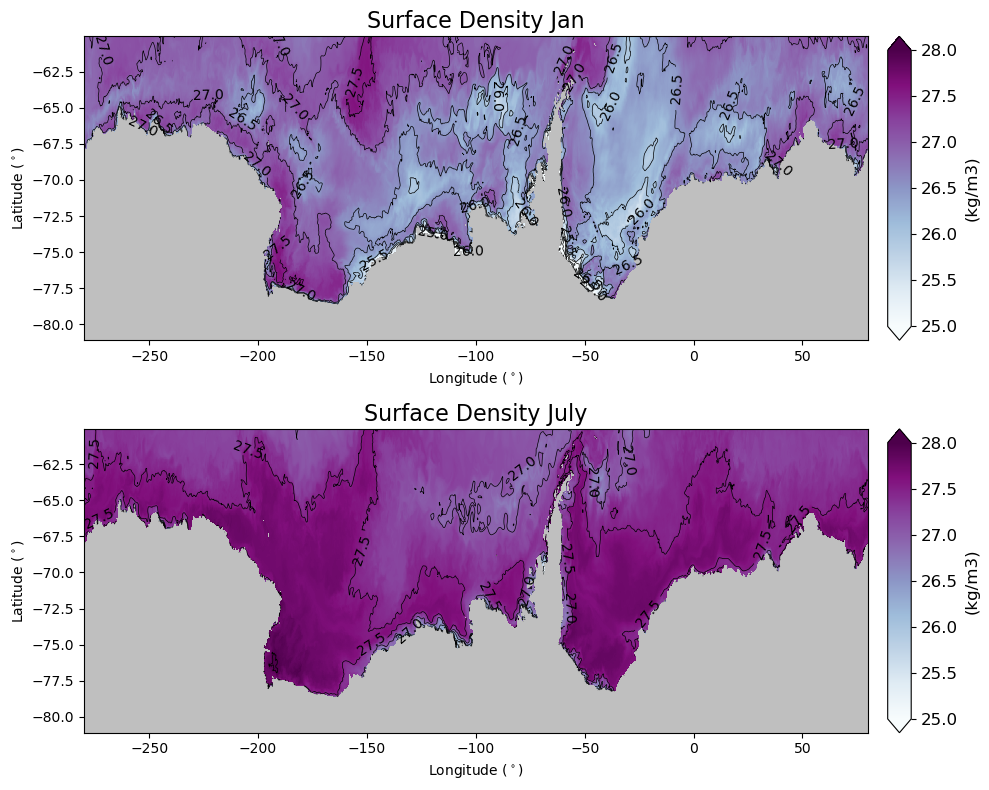

In [15]:
levels=np.arange(24., 29., 0.5)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.gca().patch.set_color('.75')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.pcolormesh(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[0],cmap=plt.cm.BuPu,vmin=25,vmax=28)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[0],levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
#plt.ylim([-66,-62])
#plt.xlim([-265,-255])
plt.title('Surface Density Jan',fontsize = 16)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'(kg/m3)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(2,1,2)
plt.gca().patch.set_color('.75')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.pcolormesh(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[6],cmap=plt.cm.BuPu,vmin=25,vmax=28)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[6],levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
#plt.ylim([-66,-62])
#plt.xlim([-265,-255])
plt.title('Surface Density July',fontsize = 16)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'(kg/m3)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()


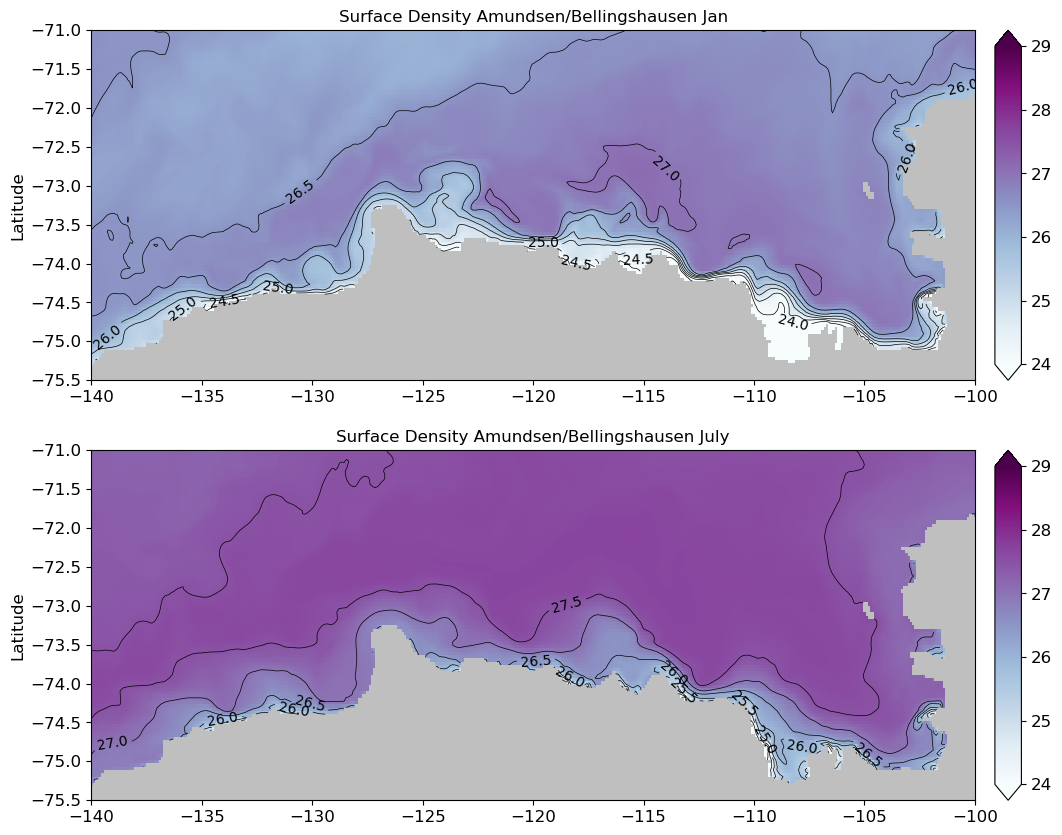

In [16]:
fontsize=12
levels=np.arange(24., 29., 0.5)


plt.figure(figsize=(12,10))

#needed for contour labels
var=pot_rho_0[0].sel(xt_ocean=slice(-150,-90))

plt.subplot(2,1,1)
plt.title('Surface Density Amundsen/Bellingshausen Jan',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
p1=plt.pcolormesh(var.xt_ocean,var.yt_ocean,var,vmin=isopycnal_bins[0],vmax=isopycnal_bins[-1],cmap=plt.cm.BuPu)
pr=plt.contour(var.xt_ocean,var.yt_ocean,var,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

var=pot_rho_0[6].sel(xt_ocean=slice(-150,-90))

plt.subplot(2,1,2)
plt.title('Surface Density Amundsen/Bellingshausen July',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
p1=plt.pcolormesh(var.xt_ocean,var.yt_ocean,var,vmin=isopycnal_bins[0],vmax=isopycnal_bins[-1],cmap=plt.cm.BuPu)
pr=plt.contour(var.xt_ocean,var.yt_ocean,var,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [17]:
ht=ht.sel(xt_ocean=lon_slice)
pot_rho_0=pot_rho_0.sel(xt_ocean=lon_slice)
pot_rho_0

,Array,Chunk
Bytes,1.18 GiB,94.92 kiB
Shape,"(180, 490, 3600)","(1, 135, 180)"
Count,936060 Tasks,14400 Chunks
Type,float32,numpy.ndarray


## calculate static differentials

In [18]:
#Ekman pumping calc ... method 2
#https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/Ekman_pumping/Ekman_pumping_zoomed_Adele.ipynb

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(expt, 'dyu', master_session, n=1)

In [19]:
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

In [20]:
dxu = cc.querying.getvar(expt, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

In [21]:
dxu

<xarray.DataArray 'dxu' (yu_ocean: 490, xu_ocean: 3600)>
dask.array<getitem, shape=(490, 3600), dtype=float32, chunksize=(490, 900), chunktype=numpy.ndarray>
Coordinates:
    TLON      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    TLAT      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    ULON      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    ULAT      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -60.12 -60.07 -60.02
Attributes:
    long_name:  U cell width through middle
    units:      m

In [22]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

## Curl Calculations

In [23]:
tau_x = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.sel(xu_ocean=lon_slice) #.resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(expt, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.sel(xu_ocean=lon_slice) #.resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [24]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [25]:
ekman = curl_tauf/rho0*s_day
# mask land:
ekman = ekman.where(ekman!=0)

In [26]:
ekman

<xarray.DataArray (time: 180, yu_ocean: 490, xu_ocean: 3600)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.0995137 ,  0.10126462,  0.06482026, ...,  0.00641467,
         -0.00522263,  0.05235458],
        [ 0.10083108,  0.10577859,  0.07314866, ...,  0.00277109,
          0.00877589,  0.06245009],
        [ 0.10721041,  0.10071329,  0.0788114 , ...,  0.00443714,
          0.02808326,  0.07821093]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.15134858,  0.16315325,  0.15535393, ...,  0.06845063,
          0.09181917,  0.12483464],
        [ 0.1453499 ,  0.16706843,  0.16758914, ...,  0.07558191,
          0.09581593,  0.12249461],
        [ 0.14173007,  0.16746885,  0.17520811, ...,  0.07495031,
          0.09792205,  0.11599143]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.26952036,  0.28324685,  0.27189724, ...,  0.16267455,
          0.20132347,  0.2441214 ],
        [ 0.26118815,  0.27856763,  0.2872159 , ...,  0.16968488,
          0.20714269,  0.2403856 ],
        [ 0.25085511,  0.26122463,  0.28424085, ...,  0.17061107,
          0.20671209,  0.23741927]]])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -60.12 -60.07 -60.02
  * time      (time) object 2150-01-16 12:00:00 ... 2164-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
    geolon_c  (yu_ocean, xu_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yu_ocean, xu_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
    TLON      (yu_ocean, xu_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yu_ocean, xu_ocean) float32 nan nan nan ... -60.05 -60.05 -60.05
    ULON      (yu_ocean, xu_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yu_ocean, xu_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02

In [27]:
# Change coords to t grid:
ekman['xu_ocean'] = ht['xt_ocean'].values
ekman['yu_ocean'] = ht['yt_ocean'].values
ekman = ekman.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [28]:
#this hangs for some reason, but file looks complete
ds = xr.Dataset({'ekman': ekman})
outpath = ekfo+time_period+'.nc'
print(outpath)

ds.to_netcdf(outpath)

ek_down_tmp_2150-2164.nc


In [29]:
#seperate zonal and meridional components
ekman_d_dx_tauyf = d_dx_tauyf/rho0*s_day
# mask land:
ekman_d_dx_tauyf = ekman_d_dx_tauyf.where(ekman_d_dx_tauyf!=0)

# Change coords to t grid:
ekman_d_dx_tauyf['xu_ocean'] = ht['xt_ocean'].values
ekman_d_dx_tauyf['yu_ocean'] = ht['yt_ocean'].values
ekman_d_dx_tauyf = ekman_d_dx_tauyf.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [30]:
ds = xr.Dataset({'ekman_d_dx_tauyf': ekman_d_dx_tauyf})
outpath = ekfo+time_period+'d_dx_tauyf.nc'
ds.to_netcdf(outpath)

In [31]:
#seperate zonal and meridional components
ekman_d_dy_tauxf = d_dy_tauxf/rho0*s_day
# mask land:
ekman_d_dy_tauxf = ekman_d_dy_tauxf.where(ekman_d_dy_tauxf!=0)

# Change coords to t grid:
ekman_d_dy_tauxf['xu_ocean'] = ht['xt_ocean'].values
ekman_d_dy_tauxf['yu_ocean'] = ht['yt_ocean'].values
ekman_d_dy_tauxf = ekman_d_dy_tauxf.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [32]:
ds = xr.Dataset({'ekman_d_dy_tauxf': ekman_d_dy_tauxf})
outpath = ekfo+time_period+'d_dy_tauxf.nc'
ds.to_netcdf(outpath)

In [33]:
#check output files
start_time='2150-01-01'
end_time='2150-12-31'


fi=ekfo+time_period+'.nc'
ek=xr.open_dataset(fi).sel(time=slice(start_time,end_time))
ek

<xarray.Dataset>
Dimensions:   (time: 12, xt_ocean: 3600, yt_ocean: 490)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2150-01-16 12:00:00 ... 2150-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 ...
    geolat_c  (yt_ocean, xt_ocean) float32 ...
    TLON      (yt_ocean, xt_ocean) float32 ...
    TLAT      (yt_ocean, xt_ocean) float32 ...
    ULON      (yt_ocean, xt_ocean) float32 ...
    ULAT      (yt_ocean, xt_ocean) float32 ...
Data variables:
    ekman     (time, yt_ocean, xt_ocean) float64 ...

In [34]:
time_monthly = ek.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(expt,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(tau_x.time)/12, 1).astype('int')
n_years = len(time_yearly)
n_days_array.values

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

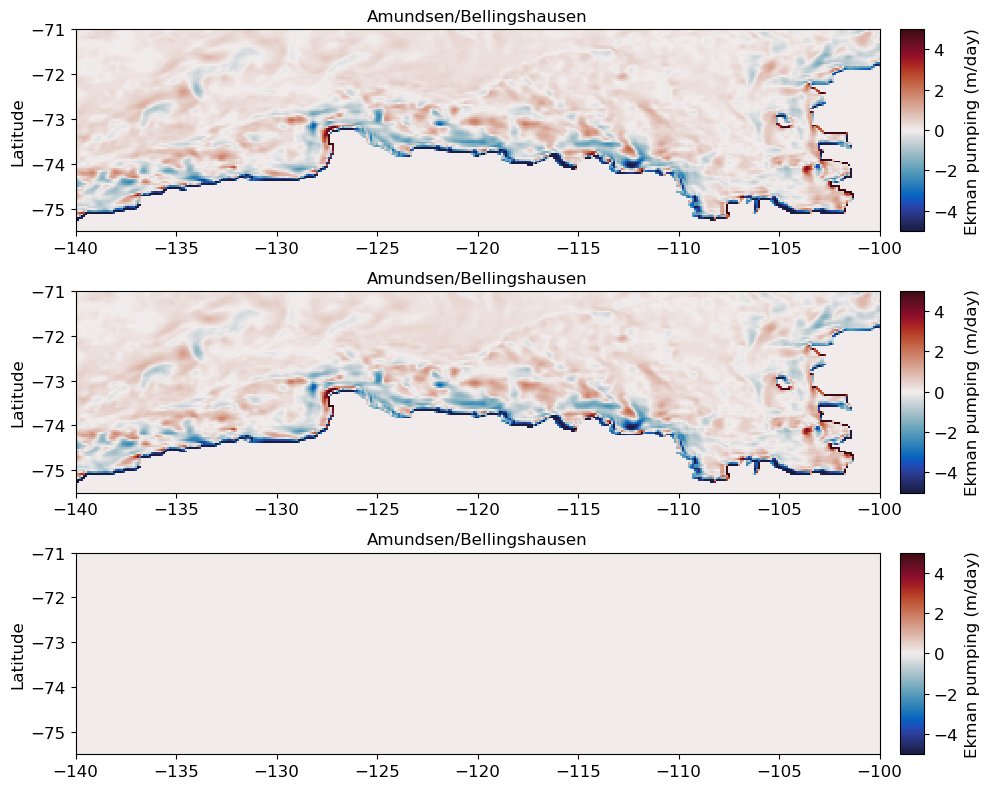

In [35]:
fontsize=12

plt.figure(figsize=(10,8))
#ekman.sum(dim='time')/sum(n_days_array)
region ='west'

plt.subplot(3,1,1)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,(ekman*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,2)

#curl_tauf = d_dx_tauyf - d_dy_tauxf
var= ekman_d_dx_tauyf-ekman_d_dy_tauxf

pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,(var*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,3)

#curl_tauf = d_dx_tauyf - d_dy_tauxf
#var= ekman_d_dx_tauyf-ekman_d_dy_tauxf

pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,(var*n_days_array-ekman*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

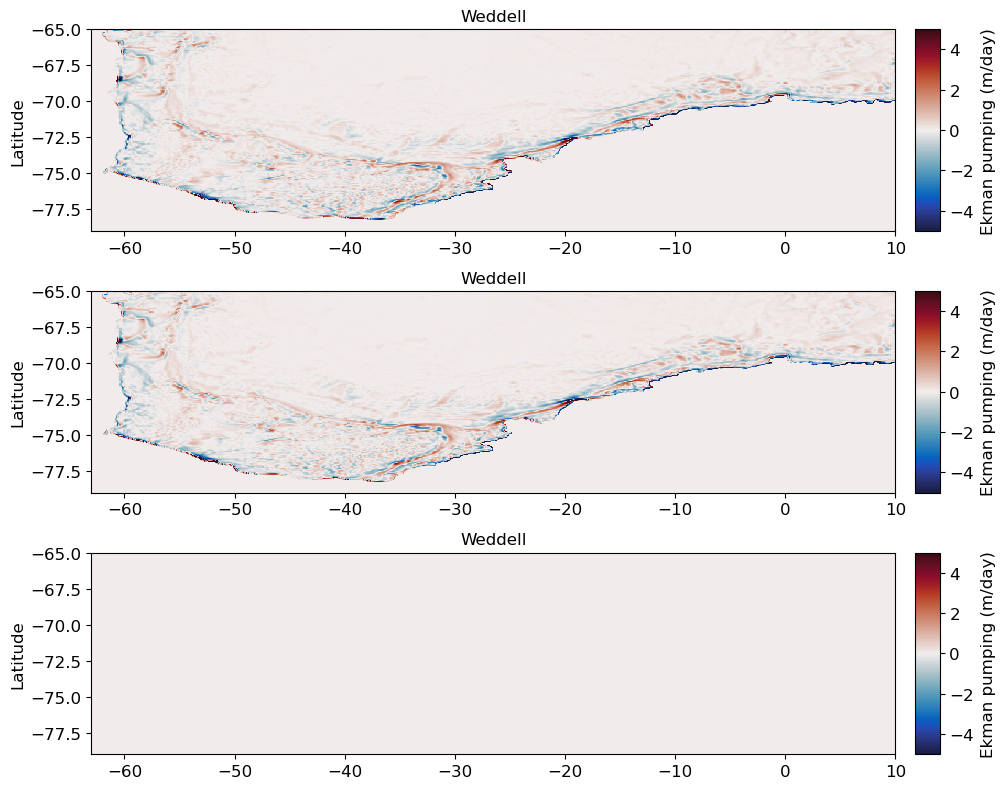

In [36]:
fontsize=12

region='east'

plt.figure(figsize=(10,8))
#ekman.sum(dim='time')/sum(n_days_array)

plt.subplot(3,1,1)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,(ekman*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,2)

#curl_tauf = d_dx_tauyf - d_dy_tauxf
var= ekman_d_dx_tauyf-ekman_d_dy_tauxf

pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,(var*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,3)

#curl_tauf = d_dx_tauyf - d_dy_tauxf
#var= ekman_d_dx_tauyf-ekman_d_dy_tauxf

pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,(var*n_days_array-ekman*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
